# Plot three-panel plot of cloud base/cloud top height distribution from w-band, SEA-POL echo top height distribution, and spatial map of echo top height

- cloud base/cloud top height from cloudnet product
- echo top height from SEA-POL volume level 4b

In [1]:
import xarray as xr
import numpy as np
import pandas as pd

from scipy.interpolate import interp2d, RectBivariateSpline
from datetime import datetime, timedelta
import cftime
import json
import glob
import os

import matplotlib.pyplot as plt
from matplotlib import rc, colors, ticker
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap
import matplotlib.ticker as mticker

import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import seaborn as sns

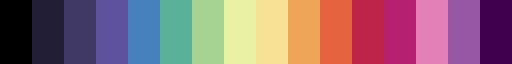

In [2]:
# Load colormap

# Read the colormap from a .txt file
def load_colormap_from_txt(file_path):
    # Load RGB values from the file
    rgb_values = np.loadtxt(file_path)
    return ListedColormap(rgb_values)

# Example usage
colormap_file = 'chase-spectral-rgb.txt'  # Replace with your .txt file path
radar_cmap = load_colormap_from_txt(colormap_file)

discrete_cmap = ListedColormap(radar_cmap(np.linspace(0, 1, 16)))
discrete_mask_cmap = discrete_cmap.copy()
discrete_mask_cmap.set_under(color='white') #set values below vmin to white
discrete_mask_cmap.set_bad(color='lightgray') #set missing (NaN) values to gray

discrete_mask_cmap

W-band cloud radar

In [3]:
# Read in data
#QmSw6jc9FrcY6tcnKw2bvHJ2NYwS5WwRjSsPxNM4fcVvTr
#wband = xr.open_dataset("ipfs://bafybeiceihwds4qy6nqxfpp7qqot7xjlpjrtv5yq3t6uwnupk3bawhnbte", engine="zarr")
wband = xr.open_dataset("ipns://latest.orcestra-campaign.org/products/METEOR/cloudnet.zarr", engine="zarr")
wband

<xarray.Dataset> Size: 7GB
Dimensions:                 (time: 106200, height: 393)
Coordinates:
  * height                  (height) float32 2kB 120.3 135.3 ... 1.198e+04
  * time                    (time) datetime64[ns] 850kB 2024-08-17T00:00:15 ....
Data variables: (12/55)
    N_scaled                (time, height) float32 167MB ...
    Tw                      (time, height) float32 167MB ...
    Z                       (time, height) float32 167MB ...
    Z_bias                  (time) float32 425kB ...
    Z_error                 (time, height) float32 167MB ...
    Z_sensitivity           (time, height) float32 167MB ...
    ...                      ...
    rain_detected           (time) float64 850kB ...
    rainfall_rate           (time) float32 425kB ...
    target_classification   (time, height) float64 334MB ...
    v                       (time, height) float32 167MB ...
    v_sigma                 (time, height) float32 167MB ...
    width                   (time, height) float32 167MB ...
Attributes: (12/18)
    Conventions:         CF-1.8
    cloudnet_file_type:  der
    title:               Cloudnet droplet effective radius on RV Meteor durin...
    location:            RV Meteor
    year:                2024
    source:              RPG-Radiometer Physics RPG-FMCW-94\nLufft CHM15k\nEC...
    ...                  ...
    platform:            RV METEOR
    institution:         Leipzig Institute for Meteorology, Leipzig University
    instrument:          Cloudnet product based on cloud radar, ceilometer, m...
    creator_id:          ORCiD: 0000-0002-1164-3576
    keywords:            Cloudnet, effective radius, droplet
    featureType:         trajectoryProfile

SEA-POL data

In [4]:
# read in data
seapol = xr.open_dataset('/huracan/tank4/cornell/ORCESTRA/sea-pol/qc_data/level4b/PICCOLO_level4b_volume_3D.nc')
seapol

<xarray.Dataset> Size: 346GB
Dimensions:       (time: 7761, Z: 19, Y: 241, X: 241)
Coordinates:
  * X             (X) float32 964B -1.2e+05 -1.19e+05 ... 1.19e+05 1.2e+05
  * Y             (Y) float32 964B -1.2e+05 -1.19e+05 ... 1.19e+05 1.2e+05
  * Z             (Z) float32 76B 0.0 1e+03 2e+03 ... 1.6e+04 1.7e+04 1.8e+04
    latitude      (time, Y, X) float32 2GB ...
    longitude     (time, Y, X) float32 2GB ...
  * time          (time) datetime64[ns] 62kB 2024-08-16T08:10:00 ... 2024-09-...
Data variables: (12/14)
    DBZ           (time, Z, Y, X) float32 34GB ...
    KDP           (time, Z, Y, X) float32 34GB ...
    PHIDP         (time, Z, Y, X) float32 34GB ...
    RAINRATE      (time, Z, Y, X) float32 34GB ...
    RHOHV         (time, Z, Y, X) float32 34GB ...
    SQI           (time, Z, Y, X) float32 34GB ...
    ...            ...
    WIDTH         (time, Z, Y, X) float32 34GB ...
    ZDR           (time, Z, Y, X) float32 34GB ...
    grid_mapping  int32 4B ...
    heading       (time) float32 31kB ...
    start_time    (time) datetime64[ns] 62kB ...
    stop_time     (time) datetime64[ns] 62kB ...
Attributes: (12/16)
    Conventions:       CF-1.12
    institution:       Colorado State University
    source:            CSU SEA-POL radar
    instrument:        SEA-POL
    title:             Level 4 Gridded SEA-POL Radar Data
    summary:           Level 4 Gridded SEA-POL Radar Data
    ...                ...
    platform:          RV METEOR
    keywords:          radar, precipitation, sea-pol
    processing_level:  Level 4
    license:           CC-BY-4.0
    history:           Thu Jun 26 07:17:23 2025: ncrcat PICCOLO_level4b_volum...
    NCO:               netCDF Operators version 4.9.7 (Homepage = http://nco....

In [5]:
# sea-pol echo top height data
seapol_echotop_all = xr.open_dataset('../../data/SEA-POL_echo_top_height.nc') #all data within 120 km, all AP times
seapol_echotop_vol1 = xr.open_dataset('../../data/SEA-POL_echo_top_height_vol1.nc') #all data within 120 km, volume 1 times only (10s)
seapol_echotop_all_50_120 = xr.open_dataset('../../data/SEA-POL_echo_top_height_50_120.nc') #all data between 50-120 km, all AP times
seapol_echotop_vol1_50_120 = xr.open_dataset('../../data/SEA-POL_echo_top_height_vol1_50_120.nc') #all data between 50-120 km, volume 1 times only (10s)
seapol_echotop = seapol_echotop_vol1

Calculate percentages of echo top height

In [20]:
#Calculate percentage of echo top heights greater than 12 km
n_echo_12km = np.size(np.where(seapol_echotop.echo_top_height.values>12000))/(np.size(seapol_echotop.echo_top_height.values))
print('Percent of echo tops > 12 km:', n_echo_12km)

#Calculate percentage of echo top heights greater than 8 km (deep convection)
n_echo_deep = np.size(np.where(seapol_echotop.echo_top_height.values>8000))/(np.size(seapol_echotop.echo_top_height.values))
print('Percent of echo tops > 8 km:', n_echo_deep)

#Calculate percentage of echo top heights less than 3 km (shallow convection)
n_echo_shallow = np.size(np.where(seapol_echotop.echo_top_height.values<3000))/(np.size(seapol_echotop.echo_top_height.values))
print('Percent of echo tops < 3 km:', n_echo_shallow)

#Calculate percentage of echo top heights between 3-8 km (congestus)
n_echo_congestus = np.size(np.where((seapol_echotop.echo_top_height.values>3000) & (seapol_echotop.echo_top_height.values<8000)))/(np.size(seapol_echotop.echo_top_height.values))
print('Percent of echo tops > 3 km and < 8 km:', n_echo_congestus)

Percent of echo tops > 12 km: 0.014632921706297276
Percent of echo tops > 8 km: 0.17620207401208263
Percent of echo tops < 3 km: 0.11163186947386033
Percent of echo tops > 3 km and < 8 km: 0.5045720410850967


Calculate SEA-POL echo top height for one single time to plot as a map

In [26]:
#Define time period for spatial map
#time_map = np.datetime64('2024-09-08T15:50')
#time_map = np.datetime64('2024-09-01T07:50')
#time_map = np.datetime64('2024-09-02T04:20')
time_map = np.datetime64('2024-09-05T18:00')

index_map = np.abs(pd.to_datetime(seapol.time) - time_map).argmin()
map_dbz = seapol.DBZ[index_map,:,:,:]

# set to nan outside of radius 120 km to only include data with the 3D volume
radius = 120  # km
distances = np.sqrt((map_dbz.latitude - map_dbz.latitude[120, 120])**2 + (map_dbz.longitude - map_dbz.longitude[120, 120])**2) * 111.32  # Approximate conversion from degrees to km
map_dbz = map_dbz.where(distances<=radius,np.nan)  # Set values outside the radius to NaN


In [27]:
#find the maximum height where the reflectivity is above a threshold
threshold = 10

# mask for valid (non-NaN) data
valid_data = ~np.isnan(map_dbz.values)

# mask for reflectivity above threshold
above_thresh = valid_data & (map_dbz.values >= threshold)

# Find the highest index (height) where above_thresh is True for each (y, x), if not found return -1
max_indices = np.where(above_thresh.any(axis=0), above_thresh.shape[0] - 1 - np.argmax(above_thresh[::-1], axis=0), -1)

# Initialize output: NaN where no valid data, -5 where threshold not met
echo_top_height = np.full(map_dbz.shape[1:], np.nan)
has_valid = valid_data.any(axis=0)
echo_top_height[has_valid] = -5

# Set echo top height where threshold is met
valid = max_indices != -1
echo_top_height[valid] = map_dbz.Z.values[max_indices[valid].astype(int)]

Compare to Delian's method of calculating echo-top height

In [12]:
"""
Find the height (in km) of the highest X dBZ echo followed by a lower value or missing (-999/nan).
Parameters:
    reflectivity (xr.DataArray): 3D DataArray with dimensions ('z', 'y', 'x').
Returns:
    xr.DataArray: 2D DataArray with height in km of 20 dBZ echo, with lat/lon coords.
"""
def find_height_DBZecho(DBZ_want, reflectivity):
    z_dim, y_dim, x_dim = reflectivity.shape
    heights = np.full((y_dim, x_dim), np.nan) #creating an empty array full of nans...
    ref = reflectivity.values  # for performance
    #looping through each point
    for j in range(y_dim):
        for i in range(x_dim):
            column = ref[:, j, i]
            if np.all(np.isnan(column)):
                continue
            # Loop from top to bottom
            for z in reversed(range(z_dim)):
                val = column[z]
                if np.isnan(val):
                    continue
                if val >= DBZ_want:
                    if z == z_dim - 1:
                        # Top level: no data above, accept
                        heights[j, i] = z
                        break
                    else:
                        above = column[z + 1]
                        if np.isnan(above) or above < DBZ_want or np.isclose(above, -9999):
                            heights[j, i] = z
                            break
    # Create new DataArray with x/y coords
        height_da = xr.DataArray(
            heights,
            dims=('Y', 'X'),
            coords={
                'X': reflectivity.X,
                'Y': reflectivity.Y,
            },
            name='echo_top_'+ str(DBZ_want)+'dBZ',
            attrs={'description': 'Height (km) of '+ str(DBZ_want)+ ' dBZ echo top'}
        )
    return height_da

In [13]:
echo_height_10= find_height_DBZecho(10, map_dbz)

Apply rain attenuation flag to w-band data

In [9]:
#exclude data where rain attenuation flag equals 1
wband_cloudbase = wband.cloud_base_height_amsl[wband.rain_attenuation_flag!=1]
wband_cloudtop = wband.cloud_top_height_amsl[wband.rain_attenuation_flag!=1]

## OR ##

#use all data
#wband_cloudbase = wband.cloub_base_height_amsl
#wband_cloudtop = wband.cloud_top_height_amsl

In [24]:
print(np.nanmean(wband_cloudbase.values))
print(np.nanmean(wband.cloud_base_height_amsl.values))

2441.714
2414.8018


Plot 

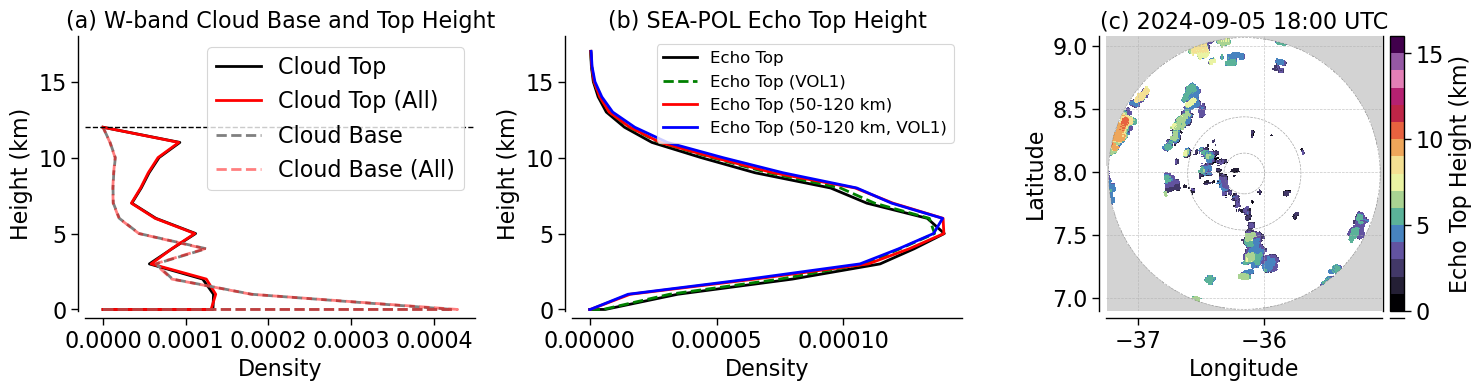

In [28]:
#Plot pdf of wband cloud base and top height
fig, axs = plt.subplots(1,3,figsize=(15,4))

bins =np.concatenate(([-1],np.arange(0, 14000, 1000)))
seapol_bins = np.concatenate(([-1],np.arange(0, 18500, 1000)))
cb_hist, bin_edges_cb = np.histogram(wband_cloudbase, bins=bins, density=True)
cb_hist2, bin_edges_cb2 = np.histogram(wband.cloud_base_height_amsl, bins=bins, density=True)
ct_hist, bin_edges_ct = np.histogram(wband_cloudtop, bins=bins, density=True)
ct_hist2, bin_edges_ct2 = np.histogram(wband.cloud_top_height_amsl, bins=bins, density=True)
eth_hist, bin_edges_eth = np.histogram(seapol_echotop_all.echo_top_height, bins=seapol_bins, density=True)
eth_hist2, bin_edges_eth2 = np.histogram(seapol_echotop_all_50_120.echo_top_height, bins=seapol_bins, density=True)
eth_hist3, bin_edges_eth3 = np.histogram(seapol_echotop_vol1_50_120.echo_top_height, bins=seapol_bins, density=True)
eth_hist4, bin_edges_eth4 =  np.histogram(seapol_echotop_vol1.echo_top_height, bins=seapol_bins, density=True)

axs[0].plot(ct_hist,bin_edges_ct[:-1]/1000,color='black', linewidth=2,label='Cloud Top')
axs[0].plot(ct_hist2,bin_edges_ct2[:-1]/1000,color='red', linewidth=2,label='Cloud Top (All)')
axs[0].plot(cb_hist,bin_edges_cb[:-1]/1000,color='gray', linestyle = '--', linewidth=2,label='Cloud Base')
axs[0].plot(cb_hist2,bin_edges_cb2[:-1]/1000,color='red', alpha = 0.5, linestyle = '--', linewidth=2,label='Cloud Base (All)')

#add a horizontal line at 12000
axs[0].axhline(12, color='black', linestyle='--', linewidth=1)

axs[0].set_xlabel('Density',fontsize=16)
axs[0].set_ylabel('Height (km)',fontsize=16)
axs[0].set_ylim([-.1,18])
axs[0].tick_params(axis='both', labelsize=16)
axs[0].legend(fontsize=16)
axs[0].set_title('(a) W-band Cloud Base and Top Height', fontsize=16)

axs[1].plot(eth_hist,bin_edges_eth[:-1]/1000,color='black', linewidth=2,label='Echo Top')
axs[1].plot(eth_hist4,bin_edges_eth4[:-1]/1000,color='green', linestyle='--', linewidth=2,label='Echo Top (VOL1)')
axs[1].plot(eth_hist2,bin_edges_eth2[:-1]/1000,color='red', linewidth=2,label='Echo Top (50-120 km)')
axs[1].plot(eth_hist3,bin_edges_eth3[:-1]/1000,color='blue', linewidth=2,label='Echo Top (50-120 km, VOL1)')

axs[1].set_xlabel('Density',fontsize=16)
axs[1].set_ylabel('Height (km)',fontsize=16)
axs[1].set_ylim([-.1,18])
axs[1].tick_params(axis='both', labelsize=16)
axs[1].legend(fontsize=12)
axs[1].set_title('(b) SEA-POL Echo Top Height', fontsize=16)

cax = axs[2].pcolormesh(map_dbz.longitude, map_dbz.latitude, echo_top_height/1000, cmap=discrete_mask_cmap, vmin=0, vmax=16)
axs[2].set_aspect('equal',adjustable='box')
cbar = fig.colorbar(cax, ax=axs[2], orientation='vertical',pad=0.02)
cbar.ax.tick_params(labelsize=16)
#cbar.set_ticks(np.linspace(-10,60,8))
cbar.ax.set_ylabel('Echo Top Height (km)', fontsize=16)
dt_str = pd.to_datetime(seapol.time[index_map].values).strftime('%Y-%m-%d %H:%M')
axs[2].set_title('(c) ' + dt_str + ' UTC',fontsize=16)
axs[2].tick_params(axis='both', labelsize=16)
axs[2].set_xlabel('Longitude', fontsize=16)
axs[2].set_ylabel('Latitude', fontsize=16)

# Add grid lines 
axs[2].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
# Add 120 km circle
axs[2].add_patch(plt.Circle((map_dbz.longitude[120,120], map_dbz.latitude[120,120]), 120/111.32, color='gray', alpha = 0.7,fill=False, linestyle='--', linewidth=0.5))
# Add 50 km circle
axs[2].add_patch(plt.Circle((map_dbz.longitude[120,120], map_dbz.latitude[120,120]), 50/111.32, color='gray', alpha = 0.7,fill=False, linestyle='--', linewidth=0.5))
# Add 18 km circle
axs[2].add_patch(plt.Circle((map_dbz.longitude[120,120], map_dbz.latitude[120,120]), 18/111.32, color='gray', alpha = 0.7,fill=False, linestyle='--', linewidth=0.5))

sns.set_context('paper') 
sns.despine(offset=5)
plt.tight_layout() 

#plt.savefig('../Plots/Fig_echo_base_top.pdf', bbox_inches='tight', dpi=300)

Removing rain attenuated data from the w-band slightly changes the cloud top distribution but it is a tiny effect. I will continue to exclude rain attenuated data but feel good that, at least for this metric, it doesn't influence the results much. It changes in a height vetween 2 and 3 km which is the height range of the signal top of these rainy cases. I'm using 1 km bins here to match the SEA-POL data; it is possible that with a finer bin size we would see a clearer shift. 

Restricting the SEA-POL echo top height distribution to within 50-120 km where there is the best 3D coverage rather than everything within 120 km doesn't change it much either; it shifts the distribution down a little bit.

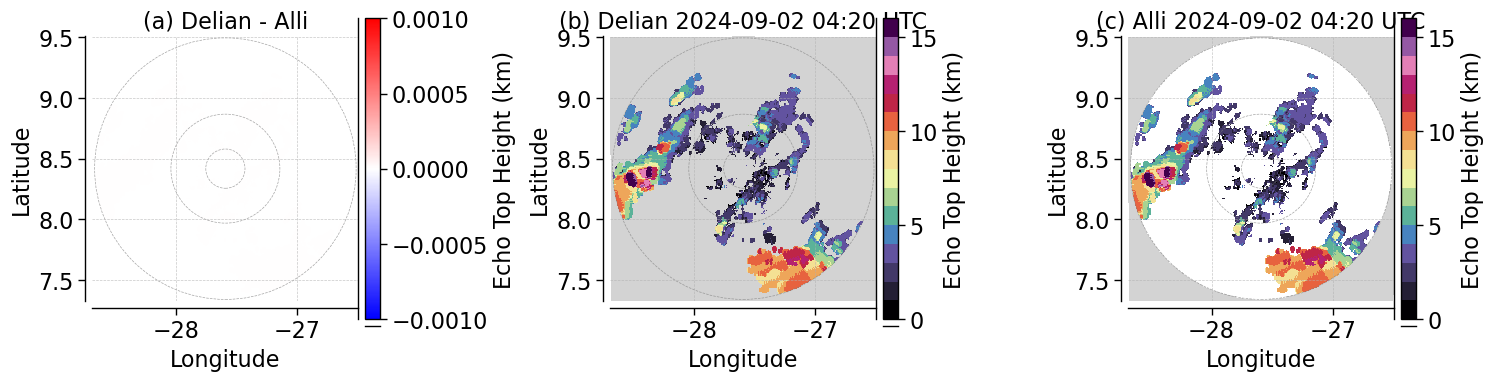

In [21]:
#compare echo top height methods
fig, axs = plt.subplots(1,3,figsize=(15,4))

cax = axs[0].pcolormesh(map_dbz.longitude, map_dbz.latitude, echo_height_10-echo_top_height/1000, cmap='bwr', vmin=-0.001, vmax=0.001)
axs[0].set_aspect('equal',adjustable='box')
cbar = fig.colorbar(cax, ax=axs[0], orientation='vertical',pad=0.02)
cbar.ax.tick_params(labelsize=16)
#cbar.set_ticks(np.linspace(-10,60,8))
cbar.ax.set_ylabel('Echo Top Height (km)', fontsize=16)
dt_str = pd.to_datetime(seapol.time[index_map].values).strftime('%Y-%m-%d %H:%M')
axs[0].set_title('(a) Delian - Alli',fontsize=16)
axs[0].tick_params(axis='both', labelsize=16)
axs[0].set_xlabel('Longitude', fontsize=16)
axs[0].set_ylabel('Latitude', fontsize=16)

# Add grid lines 
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
# Add 120 km circle
axs[0].add_patch(plt.Circle((map_dbz.longitude[120,120], map_dbz.latitude[120,120]), 120/111.32, color='gray', alpha = 0.7,fill=False, linestyle='--', linewidth=0.5))
# Add 50 km circle
axs[0].add_patch(plt.Circle((map_dbz.longitude[120,120], map_dbz.latitude[120,120]), 50/111.32, color='gray', alpha = 0.7,fill=False, linestyle='--', linewidth=0.5))
# Add 18 km circle
axs[0].add_patch(plt.Circle((map_dbz.longitude[120,120], map_dbz.latitude[120,120]), 18/111.32, color='gray', alpha = 0.7,fill=False, linestyle='--', linewidth=0.5))

cax = axs[1].pcolormesh(map_dbz.longitude, map_dbz.latitude, echo_height_10, cmap=discrete_mask_cmap, vmin=0, vmax=16)
axs[1].set_aspect('equal',adjustable='box')
cbar = fig.colorbar(cax, ax=axs[1], orientation='vertical',pad=0.02)
cbar.ax.tick_params(labelsize=16)
#cbar.set_ticks(np.linspace(-10,60,8))
cbar.ax.set_ylabel('Echo Top Height (km)', fontsize=16)
dt_str = pd.to_datetime(seapol.time[index_map].values).strftime('%Y-%m-%d %H:%M')
axs[1].set_title('(b) Delian ' + dt_str + ' UTC',fontsize=16)
axs[1].tick_params(axis='both', labelsize=16)
axs[1].set_xlabel('Longitude', fontsize=16)
axs[1].set_ylabel('Latitude', fontsize=16)

# Add grid lines 
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
# Add 120 km circle
axs[1].add_patch(plt.Circle((map_dbz.longitude[120,120], map_dbz.latitude[120,120]), 120/111.32, color='gray', alpha = 0.7,fill=False, linestyle='--', linewidth=0.5))
# Add 50 km circle
axs[1].add_patch(plt.Circle((map_dbz.longitude[120,120], map_dbz.latitude[120,120]), 50/111.32, color='gray', alpha = 0.7,fill=False, linestyle='--', linewidth=0.5))
# Add 18 km circle
axs[1].add_patch(plt.Circle((map_dbz.longitude[120,120], map_dbz.latitude[120,120]), 18/111.32, color='gray', alpha = 0.7,fill=False, linestyle='--', linewidth=0.5))

cax = axs[2].pcolormesh(map_dbz.longitude, map_dbz.latitude, echo_top_height/1000, cmap=discrete_mask_cmap, vmin=0, vmax=16)
axs[2].set_aspect('equal',adjustable='box')
cbar = fig.colorbar(cax, ax=axs[2], orientation='vertical',pad=0.02)
cbar.ax.tick_params(labelsize=16)
#cbar.set_ticks(np.linspace(-10,60,8))
cbar.ax.set_ylabel('Echo Top Height (km)', fontsize=16)
dt_str = pd.to_datetime(seapol.time[index_map].values).strftime('%Y-%m-%d %H:%M')
axs[2].set_title('(c) Alli ' + dt_str + ' UTC',fontsize=16)
axs[2].tick_params(axis='both', labelsize=16)
axs[2].set_xlabel('Longitude', fontsize=16)
axs[2].set_ylabel('Latitude', fontsize=16)

# Add grid lines 
axs[2].grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
# Add 120 km circle
axs[2].add_patch(plt.Circle((map_dbz.longitude[120,120], map_dbz.latitude[120,120]), 120/111.32, color='gray', alpha = 0.7,fill=False, linestyle='--', linewidth=0.5))
# Add 50 km circle
axs[2].add_patch(plt.Circle((map_dbz.longitude[120,120], map_dbz.latitude[120,120]), 50/111.32, color='gray', alpha = 0.7,fill=False, linestyle='--', linewidth=0.5))
# Add 18 km circle
axs[2].add_patch(plt.Circle((map_dbz.longitude[120,120], map_dbz.latitude[120,120]), 18/111.32, color='gray', alpha = 0.7,fill=False, linestyle='--', linewidth=0.5))

sns.set_context('paper') 
sns.despine(offset=5)
plt.tight_layout() 

#plt.savefig('../Plots/Fig_echo_base_top.pdf', bbox_inches='tight', dpi=300)

The two methods appear to give the same results!